# Subset discontinuity tracking
This deck contains proofing of subset splitting methodologies

Found 2 images


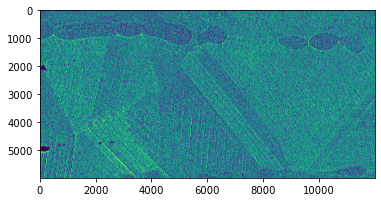

In [1]:
# preamble

import matplotlib.pyplot as plt
from pathlib import Path
from crosspy import DIC, Imset
import os

# folder path

folder_path=Path(r'C:\Alex\crosspy\data\Ben')
Images = Imset(folder_path,'tif')

plt.imshow(Images.imload([1]))




2

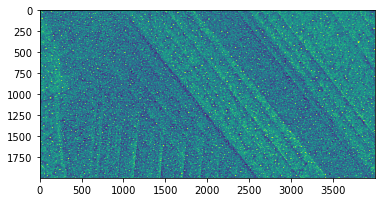

In [2]:
# Image crop

import cv2
img = Images.imload([0,1])
y = 2000
h = 2000
x = 4000
w = 4000
Images = img[y:y+h, x:x+w, :]
plt.imshow(Images[:,:,1])
Images.shape[2]



In [2]:
# first pass settings

filter_settings=[4,2,15,8]
roi_1stpass = dict(size_pass = 500, overlap_percentage = 70, xcf_mesh=600)

# first pass

dic_1stpass = DIC(Images,roi_1stpass,filter_settings)
dic_1stpass.run_sequential()

Running sequential DIC on image pair 1 of 1 ...


C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\crosspy\XCF.py:185: RuntimeWarning: invalid value encountered in multiply
  kern = ROI_ref*ne.evaluate('exp(ROI_test)')
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\crosspy\XCF.py:186: RuntimeWarning: invalid value encountered in matmul
  arg3=kernr@kern@kernc
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\crosspy\XCF.py:185: RuntimeWarning: overflow encountered in multiply
  kern = ROI_ref*ne.evaluate('exp(ROI_test)')
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\crosspy\XCF.py:186: RuntimeWarning: overflow encountered in matmul
  arg3=kernr@kern@kernc


... Completed in (s) 2323.093010663986


C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\matplotlib\image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\matplotlib\image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\matplotlib\image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


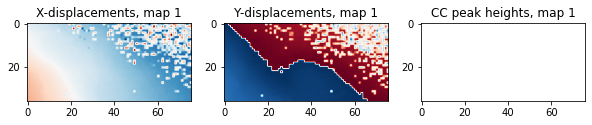

In [3]:
dic_1stpass.plot_displacements()


X shift, Y Shift, Rotation 28.593362573099416 5.206483918128667 -0.8266509829368537


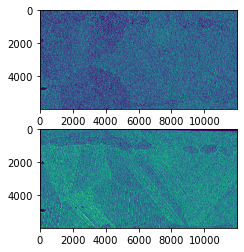

In [4]:
# Fast image transform and interpolation
import cv2
import numpy as np
from scipy.optimize import least_squares
from scipy import interpolate
import time
start_time = time.time()

def im_correct(Images,d, method='map_opencv'):

    # Function to translate and rotate images to correct for 
    # rigid body rotation and translation

    shift_x=d.dx_maps
    shift_y=d.dy_maps
    pos_x=d.x_pos
    pos_y=d.y_pos

    # Load the first image and generate pixel arrays
    if type(Images) is np.ndarray:
        image_ref = Images[:,:,0]
        images = Images
    else:
        image_ref = Images.imload([0])
        images = Images.imload([])
    x, y = np.meshgrid(range(0,np.size(image_ref,1)),range(0,np.size(image_ref,0)))
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    image_c = np.zeros(images.shape)
    image_c[:,:,0] = image_ref

    for i in range(0,images.shape[2]-1):
        # load second image and the shifts of a XCF pass
        
        im = images[:,:,i+1]
        x_shifts = shift_x[:, :, i]
        y_shifts = shift_y[:, :, i]
        
        # Correct rigid translation in x and y 
        # by subtracting the mean shift to every coordinate
        x_shifts_new = (x_shifts - np.mean(x_shifts)).flatten('F')
        y_shifts_new = (y_shifts - np.mean(y_shifts)).flatten('F')

        ## Guess rotation scheme
        # - rotation is confined between 90 degrees 
        # - with moving rotation axis
        params0 = np.array([np.size(im,1)/8, np.size(im,0)/1, -2.]) #initial [x_centre, y_centre, theta]
        ub = np.array([np.size(im,1), np.size(im,0), 45]) #upper bound [x_centre, y_centre, theta]
        lb = np.array([1, 1, -45]) #lower bound [x_centre, y_centre, theta]

        # A least squares regression scheme is utilised to approximate the 
        # centre of rotation and rotation angle
        l2_fit = rot_calc(x_shifts_new, y_shifts_new, pos_x, pos_y, params0, ub, lb)
        params1 = l2_fit.x
        
        # correct image rotation
        xc = params1[0] # Centre x
        yc = params1[1] # Centre y
        theta = params1[2] * np.pi/180 # Rotation theta
        rotation = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        # Apply corrections by creating the an array containing the
        # corrected coordinates and then mapping those coordinates
        # to existing pixel grid
                   
        if method == 'remap':
            # This method uses opencv remap - very fast
            x_cor, y_cor = x-np.mean(x_shifts), y-np.mean(y_shifts) #shifts
            points_cor = np.einsum('ji, mni -> jmn', rotation, np.dstack([x-xc, y-yc]))
            x_map = points_cor[0,:,:]+xc
            y_map = points_cor[1,:,:]+yc
            x_map = x_map.astype(np.float32)
            y_map = y_map.astype(np.float32)
            image_c[:,:,i+1] = cv2.remap(src=im, map1=x_map, map2=y_map, interpolation=cv2.INTER_CUBIC)
            
        elif method == 'affine':
            rows,cols = im.shape
            # Translation
            x_shift = -np.mean(x_shifts)
            y_shift = -np.mean(y_shifts)
            M = np.float32([[1,0,x_shift],[0,1,y_shift]])
            dst = cv2.warpAffine(im,M,(cols,rows))
            # Rotation
            M = cv2.getRotationMatrix2D((xc,yc),np.degrees(theta),1)
            image_c[:,:,i+1] = cv2.warpAffine(dst,M,(cols,rows))
    print('X shift, Y Shift, Rotation', np.mean(x_shifts), np.mean(y_shifts), np.degrees(theta))
    return image_c

def rot_calc(x_shift, y_shift, x_pos, y_pos, params0, ub, lb):
    params1 = least_squares(rotation_fun, params0, jac='3-point', bounds=(lb, ub), args=(x_shift, y_shift, x_pos.flatten('F'), y_pos.flatten('F')))
    
    return params1

def rotation_fun(params, x_shift, y_shift, x_pos, y_pos):
    # WEEEEEEEEEEEEE
    xc = params[0]
    yc = params[1]
    theta = params[2] * np.pi/180

    # calculate rotation matrix
    rotm = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    # rotate existing grid about (xc, yc)
    temp = np.column_stack((x_pos-xc,y_pos-yc))
    new_points = np.matmul(temp,rotm)

    # calculate shifts
    shifts = np.column_stack((x_pos[:]-xc-new_points[:,0], y_pos[:]-yc-new_points[:,1]))

    # Find residuals
    a = shifts[:,0]-x_shift[:]
    b = shifts[:,0]-y_shift[:]
    resids = np.column_stack((a,b))
    resids = resids.flatten('F')

    return resids

images_corrected = im_correct(dic_1stpass.ims, dic_1stpass)

f, axarr = plt.subplots(2)
axarr[0].imshow(images_corrected[:,:,0])
axarr[1].imshow(images_corrected[:,:,1])



Crop edges

In [56]:
images_corrected.shape

(2000, 4000, 2)

## Step 1 : identify subsets with kinematic discontinuities
Subsets with discontinuities may be identified by peak heigh mistmatch, extreme displacements

<IPython.core.display.Javascript object>


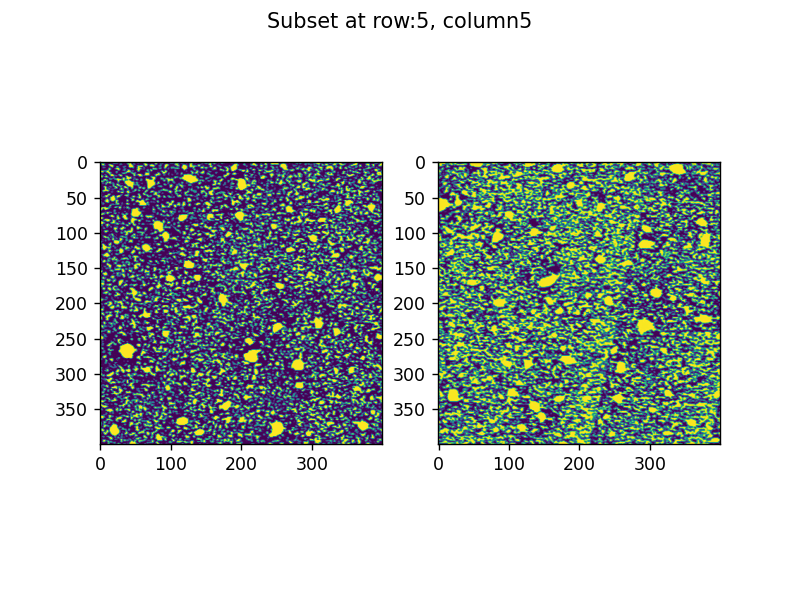

In [386]:
import cv2


#settings for heaviside pass
roi_disc = dict(size_pass = 400, overlap_percentage = 70, xcf_mesh=250)
dic_disc = DIC(images_corrected, roi_disc,filter_settings)

# Function to plot selected subsets

def get_subsets(ims, row=0, col=0, roi_settings=None):
    if roi_settings==None:
        roi_settings = dict(
            size_pass = 100, 
            overlap_percentage = 70, 
            xcf_mesh=250)
    x0 = (col) * roi_settings['size_pass']
    x1 = x0 + roi_settings['size_pass']
    y0 = (row) * roi_settings['size_pass']
    y1 = y0 + roi_settings['size_pass']
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Subset at row:{}, column{}'.format(row,col))
    images = []
    for i in range(0,ims.shape[2]):
        images.append(axs[i].imshow(ims[x0:x1, y0:y1, i]))
        
    subsets = ims[x0:x1, y0:y1, :]
    return subsets
    
# Select a subset, here at row 20, column 20

subsets = get_subsets(images_corrected,5, 5, roi_disc)



In [10]:
from numba import double, jit

<IPython.core.display.Javascript object>


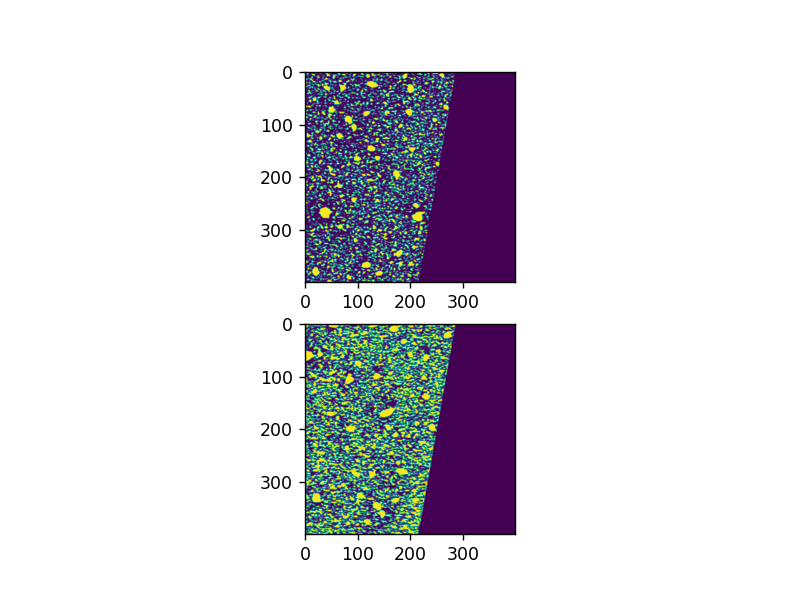

In [387]:


# Apply a line and step function

#@jit(nopython=True)

class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 
    
def line_test(pixel, r, theta, imarray):
    # Find start and end points of line segments for different cases of theta and r
    dx = imarray.shape[0]
    # Line segment to interogation point
    p1 = Point(0, 0)
    q1 = Point(pixel[0], pixel[1])
    
    # Vector magnitude cases
    
    if r == 0:
        r = 1e-8
        
    # Rotation cases
    if theta == 0. or theta == 360.: # vertical to right
        x1 = r
        x2 = q1.x
        if x2 > x1:
            return False
        else:
            return True
    elif theta == 90.: # horizontal line above
        y1 = r
        y2 = q1.y
        if y2>y1:
            return False
        else:
            return True
    elif theta == 180.: # vertical to left
        x1 = r
        x2 = q1.x
        if x2 < x1:
            return False
        else:
            return True
    elif theta == 270.: # horizontal below
        y1 = r
        y2 = q1.y
        if y2 < y1:
            return False
        else:
            return True
    elif theta>0 and theta<180:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        y1 = q1.y
        y2 = m*q1.x + c
        if y1>y2:
            return False
        else:
            return True
    elif theta>180 and theta<360:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        
        y1 = q1.y
        y2 = m*q1.x + c
        if y1<y2:
            return False
        else:
            return True
        
    

#@jit(nopython=True)
def subset_hsfilter(imarray, r, theta):
    if type(imarray) == list:
        imarray = imarray[0]
    # preallocate
    hsfilter = np.zeros((imarray.shape[0],imarray.shape[0]))
    xc = hsfilter.shape[0]/2
    yc = hsfilter.shape[1]/2
    xc = int(xc)
    yc = int(yc)
    
    # Create x and y coordinates which are centred
    xs,ys = np.meshgrid(range(-xc, xc), range(-yc,yc))
    
    
    for col in range(imarray.shape[0]):
        for row in range(imarray.shape[0]):
            #rasters through columns and rows for a given coordinate in xy
            x = xs[row,col]
            y = ys[row,col]
            # Note that y axis is mirrored
            pixel = [x, (-1*y)]
            
            # Test if pixel is beyond the discontinuity line
            if line_test(pixel, r, theta, imarray):
                hsfilter[row,col] = 1
            else:
                hsfilter[row,col] = False
                
            
                
    hs_subset = np.zeros(imarray.shape)
    hs_subset[:,:,0] = np.multiply(hsfilter,imarray[:,:,0])
    hs_subset[:,:,1] = np.multiply(hsfilter,imarray[:,:,1])
    return hs_subset


ia = subsets

result = subset_hsfilter(ia,r=50, theta=350)

f, axarr = plt.subplots(2)
axarr[0].imshow(result[:,:,0])
axarr[1].imshow(result[:,:,1])

In [391]:
from scipy.signal import correlate
def hs_corr(x, imarrays):
        
        r, theta = x
        #if r == False and theta == False:
            #filtered_subsets = imarrays
        #else:
            #apply filter
            #filtered_subsets = subset_hsfilter(imarrays, r, theta)
        
        filtered_subsets = subset_hsfilter(imarrays, r, theta)
        # flatten to 1d arrays
        undeformed = []
        test = []
        for j in range(filtered_subsets.shape[0]):
            for i in range(filtered_subsets.shape[1]):
                # We filter for False values as these correlate
                if filtered_subsets[i,j,0] == True:
                    undeformed.append(filtered_subsets[i,j,0])
                    test.append(filtered_subsets[i,j,1])
        
        undeformed = np.asarray(undeformed)
        test = np.asarray(test)
        
        norm = np.sqrt(np.dot(undeformed**2,test**2))
        undeformed = undeformed/norm
        test = test/norm
        
        # cross correlate
        
        #dxc = correlate(underformed, test, method="fft")
        dxc = np.correlate(undeformed,test)
        resids = np.log(dxc)
        
        
        return resids

hs_corr([0,40], ia)


array([-5.28590339])

We now have to use a function to identify discontinuities

In [392]:
import scipy.optimize as optimize

def disc_calc(x0, imarray, lb, ub):
    
    bounds = [(0,imarray.shape[0]/3), (0,359)]
    params = optimize.shgo(hs_corr,bounds=bounds, args=([imarray]))
    
    return params

def hs_optimisation(imarray):
    # Initial naked cross-correlation
    #dx, dy, cc = freg()
    
    # minimise to obtain an initial guess
    
    lb = [1., 1.]
    ub = [imarray.shape[0], 359.]
    x0 = [1., 90.]
    arg = imarray
    output = disc_calc(x0,imarray, lb, ub)
    print(output)
    r, theta = output.x
    return r, theta
        
    
    
    
r, theta = hs_optimisation(ia)
result = subset_hsfilter(ia,r=r, theta=theta)

f, axarr = plt.subplots(2)
axarr[0].imshow(result[:,:,0])
axarr[1].imshow(result[:,:,1])
        
    
    

IndentationError: unexpected indent (<ipython-input-392-3d7368b18dd2>, line 28)

In [393]:
# Here we map all f(r,theta) to visualise the function

r_range = range(0,150,5)
theta_range = range(0,360, 10)
z = np.zeros((len(r_range), len(theta_range)))

for i, r in enumerate(r_range):
    for j, theta in enumerate(theta_range):
        x = [r,theta]
        z0 = hs_corr(x, ia)
        print(x,z0)
        z[i,j] = z0
        


[0, 0] [-5.28875234]
[0, 10] [-5.29072582]
[0, 20] [-5.28802065]
[0, 30] [-5.28707749]
[0, 40] [-5.28590339]
[0, 50] [-5.28476603]
[0, 60] [-5.27991583]
[0, 70] [-5.27847197]
[0, 80] [-5.27880598]
[0, 90] [-5.27837714]
[0, 100] [-5.28087239]
[0, 110] [-5.27725364]
[0, 120] [-5.27417731]
[0, 130] [-5.27283184]
[0, 140] [-5.27217964]
[0, 150] [-5.27156855]
[0, 160] [-5.27138431]
[0, 170] [-5.27213116]
[0, 180] [-5.27151444]
[0, 190] [-5.26976044]
[0, 200] [-5.27239102]
[0, 210] [-5.27321861]
[0, 220] [-5.2742968]
[0, 230] [-5.27524843]
[0, 240] [-5.2797572]
[0, 250] [-5.28108757]
[0, 260] [-5.28081999]
[0, 270] [-5.28123835]
[0, 280] [-5.27879793]
[0, 290] [-5.28234341]
[0, 300] [-5.28532716]
[0, 310] [-5.28662335]
[0, 320] [-5.28741347]
[0, 330] [-5.2882957]
[0, 340] [-5.28874689]
[0, 350] [-5.28814266]
[5, 0] [-5.28980877]
[5, 10] [-5.29040814]
[5, 20] [-5.28763662]
[5, 30] [-5.28729143]
[5, 40] [-5.2880956]
[5, 50] [-5.28543027]
[5, 60] [-5.28078986]
[5, 70] [-5.27901872]
[5, 80] [-5.

[45, 270] [-5.28090135]
[45, 280] [-5.28069079]
[45, 290] [-5.28102587]
[45, 300] [-5.2811683]
[45, 310] [-5.28061691]
[45, 320] [-5.28462275]
[45, 330] [-5.2885335]
[45, 340] [-5.286773]
[45, 350] [-5.2885879]
[50, 0] [-5.28735227]
[50, 10] [-5.28897738]
[50, 20] [-5.28718833]
[50, 30] [-5.28347409]
[50, 40] [-5.28581064]
[50, 50] [-5.28569049]
[50, 60] [-5.2836617]
[50, 70] [-5.28097639]
[50, 80] [-5.27992947]
[50, 90] [-5.27875149]
[50, 100] [-5.27578162]
[50, 110] [-5.27929126]
[50, 120] [-5.27702953]
[50, 130] [-5.27380353]
[50, 140] [-5.27389551]
[50, 150] [-5.27384795]
[50, 160] [-5.27471248]
[50, 170] [-5.27229711]
[50, 180] [-5.26720193]
[50, 190] [-5.27618337]
[50, 200] [-5.27643996]
[50, 210] [-5.27602352]
[50, 220] [-5.27703254]
[50, 230] [-5.27920482]
[50, 240] [-5.27937109]
[50, 250] [-5.27836128]
[50, 260] [-5.27774498]
[50, 270] [-5.28182307]
[50, 280] [-5.28166972]
[50, 290] [-5.28065024]
[50, 300] [-5.28079411]
[50, 310] [-5.28051438]
[50, 320] [-5.28437118]
[50, 330]

[95, 150] [-5.27568681]
[95, 160] [-5.27542561]
[95, 170] [-5.27597599]
[95, 180] [-5.26432766]
[95, 190] [-5.27500949]
[95, 200] [-5.27582035]
[95, 210] [-5.27707321]
[95, 220] [-5.27830901]
[95, 230] [-5.2784936]
[95, 240] [-5.27911827]
[95, 250] [-5.27876879]
[95, 260] [-5.27896351]
[95, 270] [-5.28664335]
[95, 280] [-5.27830438]
[95, 290] [-5.27960652]
[95, 300] [-5.28127349]
[95, 310] [-5.28300778]
[95, 320] [-5.28122181]
[95, 330] [-5.28177872]
[95, 340] [-5.2858983]
[95, 350] [-5.2856874]
[100, 0] [-5.28476102]
[100, 10] [-5.28240029]
[100, 20] [-5.28330164]
[100, 30] [-5.28474196]
[100, 40] [-5.28447409]
[100, 50] [-5.28307322]
[100, 60] [-5.28213056]
[100, 70] [-5.28016092]
[100, 80] [-5.27664754]
[100, 90] [-5.27781423]
[100, 100] [-5.27668141]
[100, 110] [-5.27568985]
[100, 120] [-5.27368867]
[100, 130] [-5.27608636]
[100, 140] [-5.27614749]
[100, 150] [-5.27569065]
[100, 160] [-5.27641351]
[100, 170] [-5.27593768]
[100, 180] [-5.26509007]
[100, 190] [-5.27518435]
[100, 200]

[140, 250] [-5.2799243]
[140, 260] [-5.28089793]
[140, 270] [-5.28419792]
[140, 280] [-5.27953584]
[140, 290] [-5.28042067]
[140, 300] [-5.2803249]
[140, 310] [-5.28054864]
[140, 320] [-5.28160058]
[140, 330] [-5.28149483]
[140, 340] [-5.28095725]
[140, 350] [-5.28103094]
[145, 0] [-5.28269964]
[145, 10] [-5.28317224]
[145, 20] [-5.283028]
[145, 30] [-5.28260459]
[145, 40] [-5.28293774]
[145, 50] [-5.28234291]
[145, 60] [-5.28134018]
[145, 70] [-5.28116292]
[145, 80] [-5.28079087]
[145, 90] [-5.27974689]
[145, 100] [-5.27710619]
[145, 110] [-5.27589953]
[145, 120] [-5.2754938]
[145, 130] [-5.27523581]
[145, 140] [-5.27463475]
[145, 150] [-5.27646288]
[145, 160] [-5.2776873]
[145, 170] [-5.27741485]
[145, 180] [-5.26314351]
[145, 190] [-5.27984721]
[145, 200] [-5.28101091]
[145, 210] [-5.2801474]
[145, 220] [-5.28003244]
[145, 230] [-5.27926136]
[145, 240] [-5.27995738]
[145, 250] [-5.27960285]
[145, 260] [-5.28093272]
[145, 270] [-5.28088244]
[145, 280] [-5.27943746]
[145, 290] [-5.280

<IPython.core.display.Javascript object>


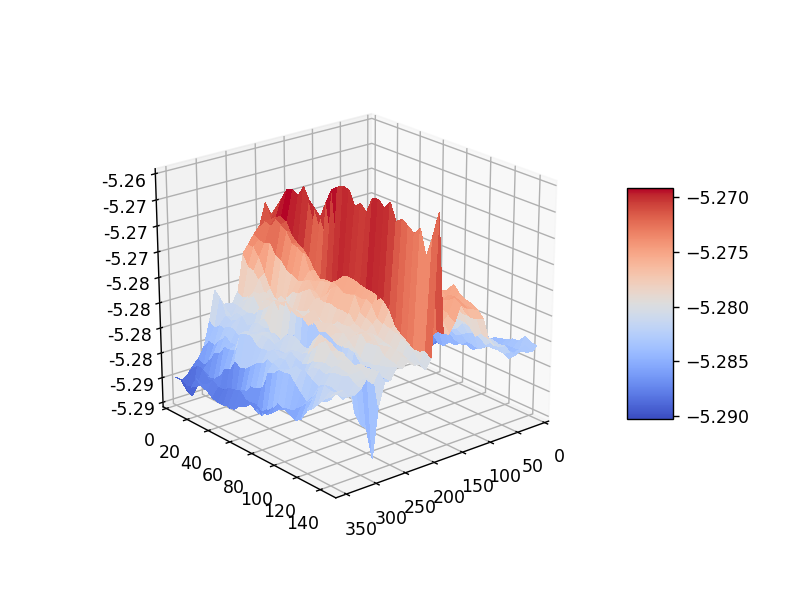

In [394]:
%matplotlib notebook
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure()
ax = fig.gca(projection='3d')

x,y = np.meshgrid(theta_range, r_range)

surf = ax.plot_surface(x,y,z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_xlim(0, 360)
ax.set_ylim(0, 150)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [369]:
z.shape

(20, 36)

## Fine pass

Running sequential DIC on image pair 1 of 1 ...
... Completed in (s) 9338.238300085068


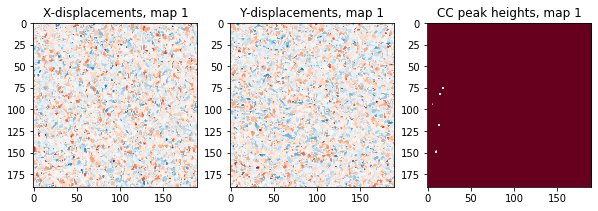

Calculating strain on map 1 of 1 ...
... Completed in (s) 27.462647914886475
Quick plotting strains


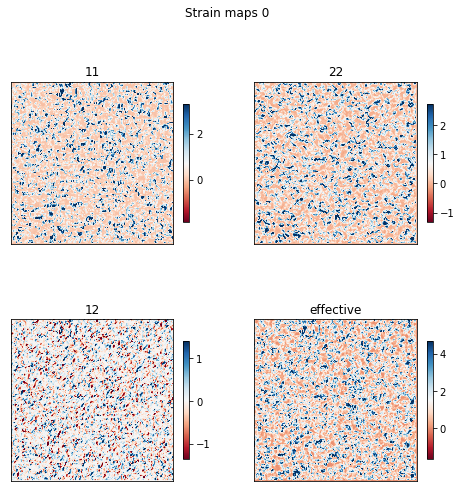

In [15]:
roi_2ndpass = dict(size_pass = 100, overlap_percentage = 90, xcf_mesh=250)
dic_2ndpass = DIC(images_corrected,roi_2ndpass,filter_settings)

# # run the second pass
dic_2ndpass.run_sequential()
dic_2ndpass.plot_displacements()

dic_2ndpass.calculate_strain(strain_method='l2')
dic_2ndpass.plot_strains()

Quick plotting strains


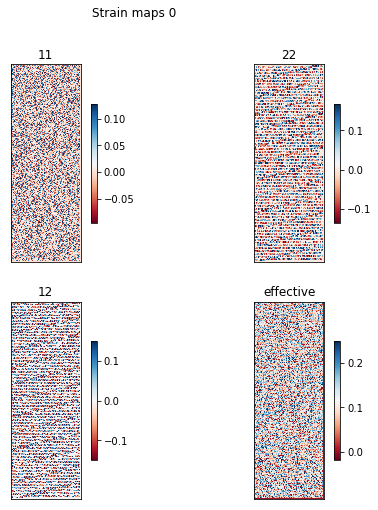

In [31]:
# # strain calc

dic_2ndpass.plot_strains()

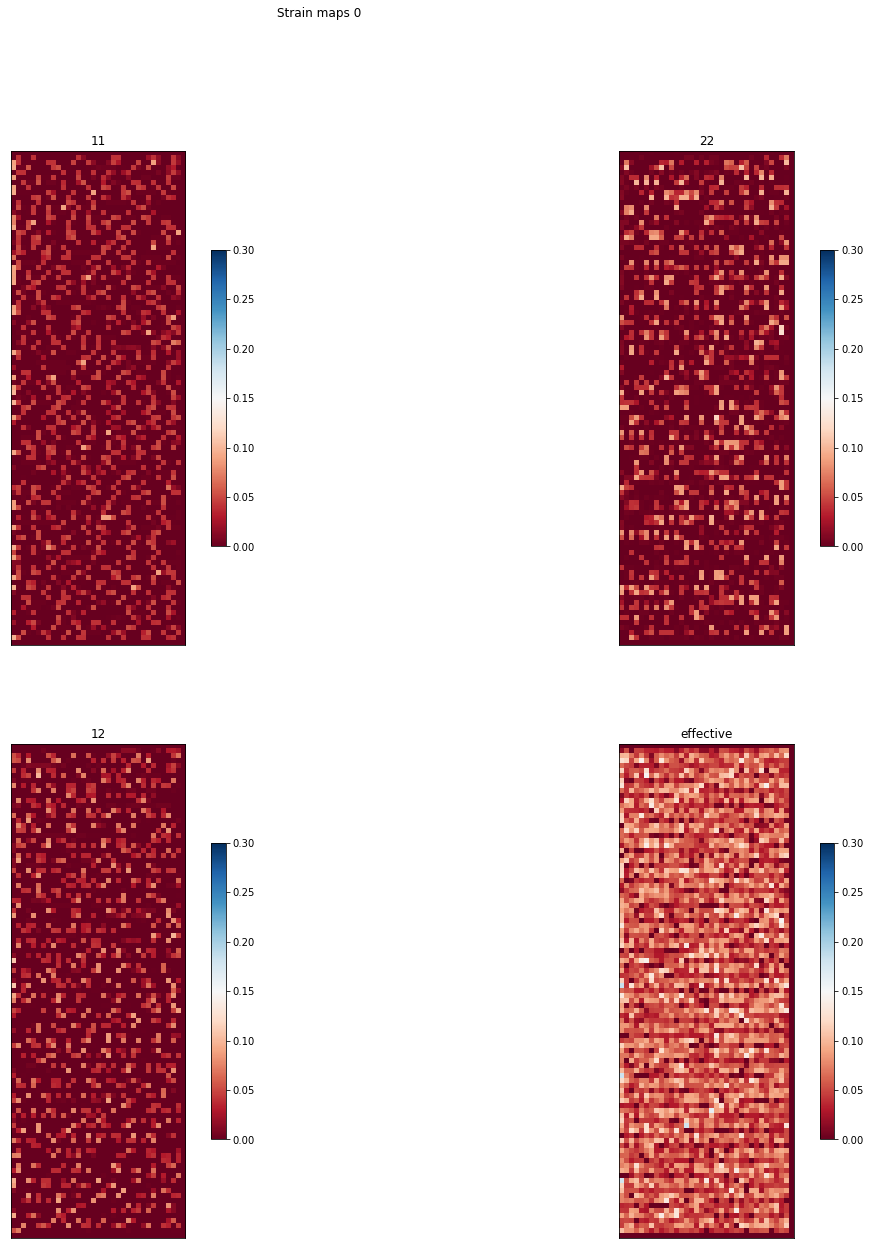

In [29]:
def plot_4(d, num, cmap):

    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    fig.suptitle('Strain maps '+str(num))
    Nr = 2
    Nc = 2
    images = []
    data = [d.strain_11[:,:,num], d.strain_22[:,:,num], d.strain_12[:,:,num], d.strain_eff[:,:,num]]
    names = ["11", "22", "12", "effective"]
    no = 0
    for i in range(Nr):
        for j in range(Nc):
            vmin = np.mean(data[no].flatten()) - 1*np.std(data[no].flatten())
            vmax = np.mean(data[no].flatten()) + 1*np.std(data[no].flatten())
            images.append(axs[i, j].imshow(data[no], cmap=cmap, vmin=0, vmax=0.3))
            axs[i, j].set_title(names[no])
            axs[i, j].label_outer()
            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            fig.colorbar(images[no], ax=axs[i,j], shrink=0.6)
            no += 1
    plt.show()
    
    
    return fig, axs

fig, axs = plot_4(dic_2ndpass, 0, 'RdBu')

fig.savefig('STRAINS_'+str(roi_2ndpass['size_pass'])+'_'+str(roi_2ndpass['overlap_percentage']), dpi=400)